Imports

In [1]:
# --- H E R E   B E   I M P O R T S --- #
#___________________________________________________________________________________
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time
import requests
import urllib.request
import io
import nltk
nltk.download('punkt')
from string import digits
from collections import Counter
import csv
from bs4 import BeautifulSoup
import scipy
import math
import random
import fileinput
from pickle import dump
import pandas
import statsmodels

import numpy as np
from numpy import array, asarray, zeros

import unicodedata
from unicodedata import normalize

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import pylab
%matplotlib inline

#!pip install Keras
#!pip install tensorflow
import tensorflow as tf
import tensorflow.data
# Seq2Seq Items
#import tensorflow.contrib.seq2seq as seq2seq
from tensorflow.python.ops.rnn_cell import LSTMCell, MultiRNNCell
#from tensorflow.contrib.seq2seq.python.ops import attention_wrapper
from tensorflow.python.layers.core import Dense

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Embedding, Input, LSTM
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


NameError: ignored

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], enable=True)

Num GPUs Available:  1


Set up for tokenization

In [ ]:
max_length = 100
tokenizer = tf.keras.preprocessing.text.Tokenizer(
num_words = None,
filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n',
lower=True,
split=' ',
char_level=False, #if True, every character is tokenized instead of word,
oov_token='eNiV')

In [ ]:
print(len(tokenizer.word_index)+1)#this is out of order--for testing

1


Data scraping 

In [ ]:
# get rid of line breaks -- used by scraper
def killbreaks(string):
    string = string.replace('\n', ' ')
    string = string.replace('\r', ' ')
    return string

In [ ]:
def sparknotesScraper(play, parity):
    '''Writes a processed .txt file for the given shakespearean play on SparkNotes.
        
        Argument: play name as spelled on SparkNotes
            ex: 'Romeo and Juliet' is romeojuliet
    
        Return: None
        
        Output: Two text files, play.txt and playCleaned.txt'''
    # i is the current page, sparknotes counts most of them in even numbers
    # which will be the training set while odd numbers will be used for the test set
    if parity == "even" :
        i=2
    if parity == "odd pt1" :
        i=3
    if parity == "odd pt2" :
        i=269
        
    print("Reading {0} from https://www.sparknotes.com/nofear/shakespeare/{0}/ ...".format(play))
    # makes a text file to which to copy <div> contents
    with open('{0}.txt'.format(play),"w+",encoding="utf-8")  as fp:
        
        # limit set at 500 pages, just to prevent infinite loop
        #    in case break statement not triggered
        while i <= 1000 :
        
            # 200 is the successful access status code. 300 are redirects
            # and above is garbage, non-200 code means the page doesn't
            # exist or is unreachable
            head = requests.head("https://www.sparknotes.com/nofear/shakespeare/{0}/page_{1}/".format(play,i))
            if head.status_code >= 300:
                print("End of visible play reached, {0} is last visible page at i={1}".format(int(i/2),i))
                break
                
            # start reading html content
            # some <div>s contain linebreaks, killbreaks() gets rid of them
            with urllib.request.urlopen("https://www.sparknotes.com/nofear/shakespeare/{0}/page_{1}/".format(play,i)) as page:
                soup = BeautifulSoup(page)
                table = soup.find("table")
                rows = table.findAll("tr")
                for row in rows:
                    for td in row.find_all("td", {"class":"noFear__cell noFear__cell--original"}):
                        for div in td.find_all("div"):
                            fp.write(killbreaks(div.text)+" ")
                        fp.write("\n")
                    for td in row.find_all("td", {"class":"noFear__cell noFear__cell--modern"}):
                        for div in td.find_all("div"):
                            fp.write(killbreaks(div.text)+" ")
                        fp.write("\n\n")
            
            if i%50 == 0:
                print("Reached page {0} at i={1},".format(int(i/2),i))
            
            i+=2
            
        print('\'{0}\' is read.'.format(play))

In [ ]:
# Plays
sparknotesScraper('hamlet', "even")
sparknotesScraper('macbeth', "even")
sparknotesScraper('romeojuliet', "even")
sparknotesScraper('lear', "even")
sparknotesScraper('juliuscaesar', "even")
sparknotesScraper('henryv', "even")
sparknotesScraper('coriolanus', "even")
sparknotesScraper('asyoulikeit', "even")
sparknotesScraper('antony-and-cleopatra', "even")
sparknotesScraper('measure-for-measure', "even")
sparknotesScraper('errors', "even")
sparknotesScraper('merchant', "even")
sparknotesScraper('msnd', "even")
sparknotesScraper('othello', "even")
sparknotesScraper('richardii', "even")
sparknotesScraper('richardiii', "even")
sparknotesScraper('shrew', "even")
sparknotesScraper('tempest', "even")
sparknotesScraper('twelfthnight', "even")
sparknotesScraper('twogentlemen', "even")
sparknotesScraper('winterstale', "even")

Reading hamlet from https://www.sparknotes.com/nofear/shakespeare/hamlet/ ...
Reached page 25 at i=50,
Reached page 50 at i=100,
Reached page 75 at i=150,
Reached page 100 at i=200,
Reached page 125 at i=250,
Reached page 150 at i=300,
End of visible play reached, 169 is last visible page at i=338
'hamlet' is read.
Reading macbeth from https://www.sparknotes.com/nofear/shakespeare/macbeth/ ...
Reached page 25 at i=50,
Reached page 50 at i=100,
Reached page 75 at i=150,
Reached page 100 at i=200,
End of visible play reached, 110 is last visible page at i=220
'macbeth' is read.
Reading romeojuliet from https://www.sparknotes.com/nofear/shakespeare/romeojuliet/ ...
Reached page 25 at i=50,
Reached page 50 at i=100,
Reached page 75 at i=150,
Reached page 100 at i=200,
Reached page 125 at i=250,
End of visible play reached, 144 is last visible page at i=288
'romeojuliet' is read.
Reading lear from https://www.sparknotes.com/nofear/shakespeare/lear/ ...
Reached page 25 at i=50,
Reached page 

In [ ]:
# store all the even indexed plays in one file for trainind
filenames = ['hamlet.txt', 'romeojuliet.txt', 'lear.txt', 'juliuscaesar.txt', 'henryv.txt', 'coriolanus.txt', 'errors.txt', 'asyoulikeit.txt','antony-and-cleopatra.txt', 'measure-for-measure.txt', 'merchant.txt', 'msnd.txt', 'othello.txt', 'richardii.txt', 'richardiii.txt', 'shrew.txt', 'tempest.txt', 'twelfthnight.txt', 'twogentlemen.txt', 'winterstale.txt']
with open('trainingSet.txt', 'w', encoding="utf-8") as outfile:
    for fname in filenames:
        with open(fname, encoding="utf-8") as infile:
            for line in infile:
                outfile.write(line)

Preprocessing

In [ ]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

def load_document(filename):
    #open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    #store in variable  
    text=file.read()
    #close it
    file.close
    return text

def make_pairs(document):
    #group the corresponding lines
    to_be_paired = document.split('\n\n')
    #pair the corresponding translations
    line_pairs = [line.split('\n') for line in to_be_paired]
    return line_pairs

#---dataset cleaning------
##Note that this is partially done by the tokenizer already
##however, we implemented our own version Before using that
##tokenizer, so we keep both for compatibility just in case
def clean(pairs, num_sentences):
    if num_sentences == 'all':
        num_sentences = len(pairs)-1
    cleaned= []
    # regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    for pair in pairs[:num_sentences]:
        clean_pair = [] 
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            # tokenize on white space
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each token
            line = [re_print.sub('', word) for word in line]
            # remove tokens with numbers in them
            line = [word.translate(str.maketrans('', '', digits)) for word in line]
            # add space before punctuation
            line = [re.sub('([.,!?()])', r' \1 ', word) for word in line]
            # remove extra spaces
            line = [re.sub(' +', ' ', word) for word in line]
            # store as string
            clean_pair.append(' '.join(line))
        # keep only pairs of 2
        if len(clean_pair) == 2:
            # split into sentences instead of lines
            if len(nltk.tokenize.sent_tokenize(clean_pair[0])) > 1 :
                first = nltk.tokenize.sent_tokenize(clean_pair[0])
                second = nltk.tokenize.sent_tokenize(clean_pair[1])
                # add a start and an end token to the sentences
                first = ['<start> ' + sentence + ' <end>' for sentence in first]
                second = ['<start> ' + sentence + ' <end>' for sentence in second]
                length = min(len(first), len(second))
                i=0
                while i < length :
                # keep only short sentences and verify the lengths are about the same
                    if len(first[i]) < max_length +15 and (2.5*len(first[i]) > len(second[i]) or 2.5*len(first[i]) > len(second[i])):
                         cleaned.append([first[i],second[i]])
                    i+=1
            else :
                # keep only short sentences
                if len(clean_pair[0]) < max_length :
                    # add a start and an end token to the sentences
                    clean_pair = ['<start> ' + sentence + ' <end>' for sentence in clean_pair]
                    cleaned.append(clean_pair)
    #print(cleaned)
    return zip(*cleaned)

def load_dataset(path, num_sentences):
    # load dataset
    doc = load_document(path)
    # split into pairs
    pairs = make_pairs(doc)
    #clean sentences
    cleaned_pairs = clean(pairs, num_sentences)
    # associate sentences to their respective language 
    shakespeare, modern = cleaned_pairs
    # make a vocabulary and fit the tokenizer on it
    vocabularySource = shakespeare + modern
    tokenizer.fit_on_texts(vocabularySource)
    # vectorize
    modern_vector = pad(tokenize(modern))
    shakespeare_vector = pad(tokenize(shakespeare))
    
    return modern_vector, shakespeare_vector, vocabularySource

def pad(language_vector):
    for sentence in language_vector:
        # add 0s to sentence vector until it is the same length as max_length
        for i in range(len(sentence), max_length):
            sentence.append(0) 
    return language_vector

def tokenize(array):
    token = tokenizer.texts_to_sequences(array)
    return token

In [ ]:
# uncomment this cell to mount drive
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# run this line if you are using jupyter
modern_vector, shakespeare_vector, vocabularySource = load_dataset('trainingSet.txt', 'all')
# uncomment this line instead if you are using drive
#modern_vector, shakespeare_vector, vocabularySource = load_dataset('/content/gdrive/MyDrive/text_files/trainingSet.txt', 'all')

-------------------------------------------
The vast majority of what follows is unoriginal -- we were authorized to make use of pre-built libraries such as scikit-learn, but to our knowledge, there exists no ready-made transformer translator, and we were (rather unsurprisingly) unable to create our own.

The principal source is thus: https://www.tensorflow.org/tutorials/text/transformer

The modifications, where they occur, are mostly for dataset compatibility -- ours and the tutorials' were different and we did not have the same capabilities or built-in functions such as tokenizers.

Positional Encoding

(1, 2048, 512)


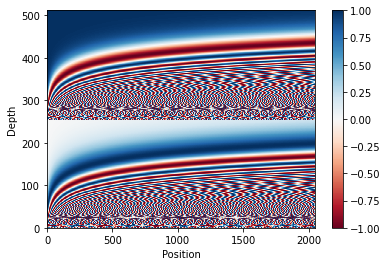

In [ ]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],np.arange(d_model)[np.newaxis, :],d_model)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2,1,0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

Padding Mask

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, -1), tf.float32)
    # add extra dimensions to add the padding to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

Attention

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

      Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

      Returns:
        output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [ ]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

Encoder and Decoder Layers

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

Encoder and Decoder

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [ ]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

Transformer model

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.tokenizer = Encoder(num_layers, d_model, num_heads, dff,  input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):

        enc_output = self.tokenizer(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [ ]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [ ]:
#Settings/parameters and model initialization
#While mostly arbitrary, these hyperparameters
#were inspired by the Attention is All You Need
#paper
num_layers = 6
d_model = 128
dff = 1024
num_heads = 16
dropout_rate = 0.2

transformer = Transformer( num_layers=num_layers,
                           d_model=d_model,
                           num_heads=num_heads,
                           dff=dff,
                           input_vocab_size=len(tokenizer.word_index)+1,
                           target_vocab_size=len(tokenizer.word_index)+1, 
                           pe_input=1000, 
                           pe_target=1000,
                           rate=dropout_rate)

Schedule

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

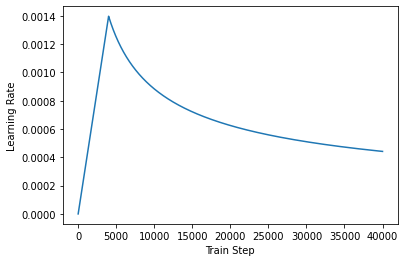

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

Loss and accuracy functions 

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [ ]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
tensormodEngENC = tf.convert_to_tensor(modern_vector, dtype=tf.int64)
tensorshakeEngENC = tf.convert_to_tensor(shakespeare_vector, dtype=tf.int64)
dataset = tf.data.Dataset.from_tensor_slices((tensormodEngENC,tensorshakeEngENC))

#This function is technically useless, but included for
#compatibility -- the tutorial source we used does more
#with it, but it is not needed in our implementation.
#Unfortunately, it is called in a complicated (for us) way.
def tokenize_pairs(sha, mod):
    return sha, mod

In [ ]:
#Partition dataset into batches for training
BUFFER_SIZE = 20000
BATCH_SIZE = 100
def make_batches(ds):
    return (
        ds
        .cache()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
        .prefetch(tf.data.AUTOTUNE))

dset = make_batches(dataset)

In [ ]:
#Weights are saved as checkpoints
checkpoint_path = "/content/gdrive/MyDrive/checkpoints_new/train"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


Training - do not run

In [ ]:
#Setup for training
EPOCHS = 600   # <<<================||X+

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                         True, 
                                         enc_padding_mask, 
                                         combined_mask, 
                                         dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
# --- T R A I N I N G --- #
# GPUs BEWARE
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> english, tar -> shakespearean
    for (batch, (inp, tar)) in enumerate(dset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print (f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 0.2870 Accuracy 0.9255
Epoch 1 Batch 50 Loss 0.2689 Accuracy 0.9282
Epoch 1 Batch 100 Loss 0.2788 Accuracy 0.9254
Epoch 1 Batch 150 Loss 0.2844 Accuracy 0.9233
Epoch 1 Batch 200 Loss 0.2923 Accuracy 0.9209
Epoch 1 Batch 250 Loss 0.3005 Accuracy 0.9186
Epoch 1 Batch 300 Loss 0.3091 Accuracy 0.9164
Epoch 1 Loss 0.3113 Accuracy 0.9160
Time taken for 1 epoch: 183.03 secs

Epoch 2 Batch 0 Loss 0.2621 Accuracy 0.9241
Epoch 2 Batch 50 Loss 0.2769 Accuracy 0.9250
Epoch 2 Batch 100 Loss 0.2834 Accuracy 0.9223
Epoch 2 Batch 150 Loss 0.2890 Accuracy 0.9209
Epoch 2 Batch 200 Loss 0.2937 Accuracy 0.9196
Epoch 2 Batch 250 Loss 0.3010 Accuracy 0.9175
Epoch 2 Batch 300 Loss 0.3084 Accuracy 0.9157
Epoch 2 Loss 0.3120 Accuracy 0.9148
Time taken for 1 epoch: 182.62 secs

Epoch 3 Batch 0 Loss 0.2431 Accuracy 0.9276
Epoch 3 Batch 50 Loss 0.2760 Accuracy 0.9246
Epoch 3 Batch 100 Loss 0.2831 Accuracy 0.9224
Epoch 3 Batch 150 Loss 0.2896 Accuracy 0.9206
Epoch 3 Batch 200 Loss 0.2967 Accur

Translation

In [ ]:
#The transformer functions by building an output 
#word-by-word, starting from the <start> token
#that signifies the beginning of a sentence.
#There is a significant number of unused content
#in this method. We were not able to implement
#these before the D3 submission deadline.
def evaluate(sentence):
    sentence = tokenizer.texts_to_sequences([sentence])
    difference = max_length - len(sentence[0])
    while difference > 0:
        sentence[0].append(0)
        difference = difference - 1
    encoder_input = tf.convert_to_tensor(sentence)
    encoder_input = tf.cast(encoder_input, tf.int32)
    start = 2
    end = 3
    output = [2]
    output = tf.convert_to_tensor([output])
    output = tf.cast(output, tf.int32)
    for i in range(max_length):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
        predictions = predictions[: ,-1:, :]
        predicted_id = tf.argmax(predictions, axis=-1)
        predicted_id = tf.cast(predicted_id, tf.int32)
        output = tf.cast(output, tf.int32)
        output = tf.concat([output, predicted_id], axis=-1)
        if predicted_id == end:
            break
    arrayn = output.numpy()
    text = tokenizer.sequences_to_texts(arrayn)

    return text, attention_weights

In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it. 
    translated_tokens = translated_tokens[1:]

    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))


    labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_xticklabels(labels, rotation=90)

    labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)


In [ ]:
sentence = "<start> he leaves me to my own contentment ,  but thats the one thing i cannot find . <end>"

translated_text, attention_weights = evaluate(sentence)
#print(attention_weights.shape)

In [ ]:
print(translated_text)

['<start> give him a humble hand , call him back . <end>']


In [ ]:
#sentence = "<start> i swear to god , i am exceedingly tired . <end>"

#translated_text, attention_weights = evaluate(sentence)
#print(translated_text)
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer3_block2'], 0)
attention = attention_heads[head]
attention.shape
#print(attention)

TensorShape([11, 100])

In [ ]:
experiment = ['one','two','three','four','five','six','seven','eight','nine','ten','eleven','twelve','thirteen','fourteen','fifteen']
experiment = tf.convert_to_tensor(experiment)

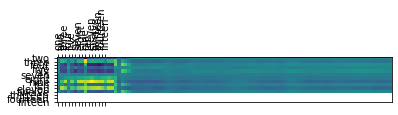

In [ ]:
plot_attention_head(experiment, experiment, attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):

    fig = plt.figure(figsize=(16, 8))

    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(2, 4, h+1)

        plot_attention_head(translated_tokens, translated_tokens, head)

        ax.set_xlabel('Head {}'.format(h+1))

    plt.tight_layout()
    plt.show()

ValueError: ignored

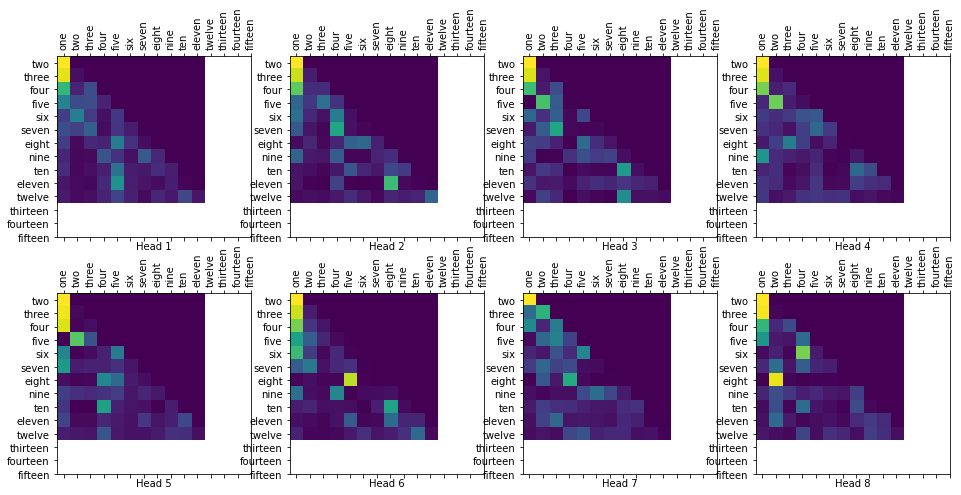

In [ ]:
plot_attention_weights(sentence, experiment,attention_weights['decoder_layer6_block1'][0])

Sample outputs

In [ ]:
sentence = "<start> i jbdfghfgdhdfghdfgh <end>"
print(evaluate(sentence)[0])

(['<start> i am resolved on a court . <end>'], {'decoder_layer1_block1': <tf.Tensor: shape=(1, 16, 8, 8), dtype=float32, numpy=
array([[[[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [8.91705871e-01, 1.08294122e-01, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [6.27031922e-01, 1.77565858e-01, 1.95402205e-01, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [3.10916513e-01, 9.46637839e-02, 1.64046615e-01, ...,
          1.12720788e-01, 0.00000000e+00, 0.00000000e+00],
         [3.05294156e-01, 2.00240955e-01, 8.62307250e-02, ...,
          1.19285569e-01, 3.52751054e-02, 0.00000000e+00],
         [9.75426137e-01, 6.78591838e-04, 1.08500745e-03, ...,
          1.25490071e-03, 1.03272228e-04, 6.38555181e-13]],

        [[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
  

In [ ]:
sentence = "<start> juliet <end>"
print(evaluate(sentence)[0])

(['<start> juliet <end>'], {'decoder_layer1_block1': <tf.Tensor: shape=(1, 16, 2, 2), dtype=float32, numpy=
array([[[[1.        , 0.        ],
         [0.6700952 , 0.32990485]],

        [[1.        , 0.        ],
         [0.17739664, 0.82260334]],

        [[1.        , 0.        ],
         [0.9728928 , 0.02710711]],

        [[1.        , 0.        ],
         [0.9861921 , 0.01380792]],

        [[1.        , 0.        ],
         [0.8243811 , 0.17561887]],

        [[1.        , 0.        ],
         [0.8723922 , 0.12760781]],

        [[1.        , 0.        ],
         [0.02206898, 0.977931  ]],

        [[1.        , 0.        ],
         [0.86183745, 0.1381625 ]],

        [[1.        , 0.        ],
         [0.9481114 , 0.05188864]],

        [[1.        , 0.        ],
         [0.97909456, 0.02090548]],

        [[1.        , 0.        ],
         [0.81110317, 0.18889686]],

        [[1.        , 0.        ],
         [0.96843475, 0.03156519]],

        [[1.        , 0.    

In [ ]:
sentence = "<start> i swear to god , i am exceedingly tired . <end>"
print(evaluate(sentence)[0])

(['<start> now , by two headed monster , nature makes me see a dream . <end>'], {'decoder_layer1_block1': <tf.Tensor: shape=(1, 16, 15, 15), dtype=float32, numpy=
array([[[[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [7.94965982e-01, 2.05034092e-01, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [6.39460146e-01, 1.65174752e-01, 1.95365071e-01, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [1.34312332e-01, 3.97762284e-02, 1.00210041e-01, ...,
          1.06576964e-01, 0.00000000e+00, 0.00000000e+00],
         [1.62551343e-01, 2.29487475e-02, 4.64060530e-02, ...,
          2.90424973e-01, 9.37284902e-03, 0.00000000e+00],
         [9.18574691e-01, 4.28809552e-04, 1.82312615e-02, ...,
          7.86131714e-03, 4.35665879e-06, 1.18891693e-11]],

        [[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 

In [ ]:
sentence = "<start> i swear to god , i am exceedingly tired . <end>"
print(evaluate(sentence)[0])

['<start> now , by two headed monster , nature makes me see a dream . <end>']


In [ ]:
sentence = "<start> hello , how are you ? <end>"
print(evaluate(sentence)[0])

['<start> how now , what sayst thou ? <end>']


In [ ]:
sentence = "<start> i do not speak very well . <end>"
print(evaluate(sentence)[0])

['<start> i have done so , and therefore speak no more . <end>']


BLEU score

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
# creating a test set with the plays that have odd indices (henry4pt1 and henry4pt2)
sparknotesScraper('henry4pt1', "odd pt1")
sparknotesScraper('henry4pt2', "odd pt2")

filenames = ['henry4pt1.txt', 'henry4pt2.txt']
with open('testSet.txt', 'w', encoding="utf-8") as outfile:
    for fname in filenames:
        with open(fname, encoding="utf-8") as infile:
            for line in infile:
                outfile.write(line)

In [ ]:
# Computing the BLEU score for the test set

# load dataset
test_doc = load_document('/content/gdrive/MyDrive/text_files/testSet.txt')
# split into pairs
test_pairs = make_pairs(test_doc)
#clean sentences
cleaned_test_pairs = clean(test_pairs, 'all')
#associate sentences to their respective language 
input_test, target_test = cleaned_test_pairs

sum_bleu = 0

for i in range(len(input_test)) :
    # set our translation and target
    sentence = evaluate(input_test[i])[0]
    target = [target_test[i]]
    # split by words, remove the start and end tokens 
    sentence = [ word.split() for word in sentence ][0][1:-1]
    target = [ word.split() for word in target ][0][1:-1]
    # compute bleu score
    curr_bleu = sentence_bleu([target],sentence)
    print('BLEU score -> {}'.format(curr_bleu))
    sum_bleu += curr_bleu

test_average_bleu = sum_bleu/len(input_test)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score -> 0.8055344092731546
BLEU score -> 0.5555238068023582
BLEU score -> 0.5475182535069453
BLEU score -> 0.5811850816158368
BLEU score -> 0.7071067811865476
BLEU score -> 0.6223329772884784
BLEU score -> 0.7400828044922853


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score -> 0.2752910796987188
BLEU score -> 0
BLEU score -> 0.45622720708659226
BLEU score -> 0.5475182535069453
BLEU score -> 0.5946035575013605
BLEU score -> 0.5081327481546147
BLEU score -> 0.5773502691896257
BLEU score -> 0.5773502691896257
BLEU score -> 0.5773502691896257
BLEU score -> 0.537284965911771
BLEU score -> 0.5623413251903491
BLEU score -> 0
BLEU score -> 0.6042750794713536
BLEU score -> 0
BLEU score -> 0.35930411196308426
BLEU score -> 0.6529942057256104
BLEU score -> 0.4165926999433137
BLEU score -> 0.668740304976422
BLEU score -> 0.6865890479690392
BLEU score -> 0.6147881529512643
BLEU score -> 0.6147881529512643
BLEU score -> 0.6262844962765469
BLEU score -> 0.5124797359336637
BLEU score -> 0
BLEU score -> 0.5555238068023582
BLEU score -> 0.668740304976422
BLEU score -> 0.5773502691896257
BLEU score -> 0.15882481735499007
BLEU score -> 0.429379141889796
BLEU score -> 0.3575297164449809
BLEU score -> 0.5773502691896257
BLEU score -> 0.13501633901742352
BLEU score -

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score -> 0.1717218426146756
BLEU score -> 0
BLEU score -> 0.4854917717073234
BLEU score -> 0.7187737616553884
BLEU score -> 0.42888194248035344
BLEU score -> 0.5491004867761125
BLEU score -> 0.5235215949109693
BLEU score -> 0.6799308458396492
BLEU score -> 0.35930411196308426
BLEU score -> 0.5695988432761473
BLEU score -> 0.5169731539571706
BLEU score -> 0.6262844962765469
BLEU score -> 0.5506953149031837
BLEU score -> 0
BLEU score -> 0.668740304976422
BLEU score -> 0.5773502691896257
BLEU score -> 0.7447819789879647
BLEU score -> 0.7071067811865476
BLEU score -> 0.6548907866815301
BLEU score -> 0.5623413251903491
BLEU score -> 0.7730551756939454
BLEU score -> 0.4212172547055404
BLEU score -> 0.1382932529237074
BLEU score -> 0.5555238068023582
BLEU score -> 0.46199933699457096
BLEU score -> 0.43645382979233377
BLEU score -> 0.5773502691896257
BLEU score -> 0.6865890479690392
BLEU score -> 0.3670124608961283
BLEU score -> 0.27952792741962756
BLEU score -> 0.16954225822593183
BLEU s

In [ ]:
# Computing the BLEU score on a small batch of the training set

# load dataset
training_doc = load_document('/content/gdrive/MyDrive/text_files/trainingSet.txt')
# split into pairs
training_pairs = make_pairs(training_doc)
#clean sentences
cleaned_training_pairs = clean(training_pairs, 'all')
#associate sentences to their respective language 
input_training, target_training = cleaned_training_pairs

sum_bleu = 0

for i in range(500) :
    # set our translation and target
    sentence = evaluate(input_training[i])[0]
    target = [target_training[i]]
    # split by words, remove the start and end tokens 
    sentence = [ word.split() for word in sentence ][0][1:-1]
    target = [ word.split() for word in target ][0][1:-1]
    # compute bleu score
    curr_bleu = sentence_bleu([target],sentence)
    print('BLEU score -> {}'.format(curr_bleu))
    sum_bleu += curr_bleu

training_average_bleu = sum_bleu/500

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score -> 0.3639412530979476


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score -> 1.0


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score -> 0.6389431042462724
BLEU score -> 0.7071067811865476
BLEU score -> 0.6042750794713536
BLEU score -> 0.30934850332660563
BLEU score -> 0.18762935180380186
BLEU score -> 0.5946035575013605
BLEU score -> 0.6511126026643229
BLEU score -> 0.7071067811865476
BLEU score -> 0.537284965911771
BLEU score -> 0.6389431042462724
BLEU score -> 0.5408536609893481
BLEU score -> 0.3670124608961283
BLEU score -> 0.7825422900366437
BLEU score -> 0.5962494769762219
BLEU score -> 0.7311104457090247
BLEU score -> 0
BLEU score -> 1.0
BLEU score -> 0.7788007830714049
BLEU score -> 0.6147881529512643
BLEU score -> 0.8408964152537145
BLEU score -> 0.7598356856515925
BLEU score -> 0
BLEU score -> 0.5946035575013605
BLEU score -> 0.7071067811865476
BLEU score -> 0.6865890479690392
BLEU score -> 0
BLEU score -> 0.8408964152537145
BLEU score -> 0.5491004867761125
BLEU score -> 0.5266403878479265
BLEU score -> 1.0
BLEU score -> 0.6529942057256104
BLEU score -> 0.6803749333171202
BLEU score -> 0.65489078

In [ ]:
print("BLEU score for the training set : "+ str(training_average_bleu))
print("BLEU score for the test set : "+ str(test_average_bleu))

BLEU score for the training set : 0.5057138533013059
BLEU score for the test set : 0.4577821393596426


Generating output from keyboard input

In [2]:
def translate(sentence) :
    # set the translation, remove the start and end tokens 
    translation = evaluate(sentence)[0][0][8:-5]
    # capitalize the first letter
    translation = translation.capitalize()
    # capitalize i's
    translation = translation.replace(" i ", " I ") 
    # remove spaces around punctuation
    translation = translation.replace(" . ", ".")
    translation = translation.replace(" ,", ",")
    translation = translation.replace(" ? ", "?")
    translation = translation.replace(" ! ", "!")
    translation = translation.replace(" \' ", "\'")
    translation = translation.replace(" \" ", "\"")
    return translation 